<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center">Time Series Analysis</h1>
<h2 style = "text-align:center">Univariate time series - Complex case (no seasonality/cyclic behaviour, missing dates) - Stock evolution  </h2>

<h2 style = "text-align:center">LSTM</h2>
<h4 style = "text-align:center">Didier Law-Hine</h4>
<h4 style = "text-align:center">August 2022</h4>

<hr style="border-width:2px;border-color:#75DFC1">


For LSTM model, important parameters to be tuned :
- the number of lag $n$ to account for the prediction of  $y_t$ :  $y_{t-1},y_{t-2}, ... , y_{t-n}$. Here, $n$=30 typically
- number of hidden layers and units in each layer. Here, 1 layer of 50 units.
- epochs and batch size. Here, typically epochs=80, batch size=20

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import sqrt
from numpy import concatenate
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,8

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smgt

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from pmdarima.arima import auto_arima
from sktime.forecasting.arima import AutoARIMA

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1235 non-null   datetime64[ns]
 1   Open                  1235 non-null   float64       
 2   High                  1235 non-null   float64       
 3   Low                   1235 non-null   float64       
 4   Last                  1235 non-null   float64       
 5   Close                 1235 non-null   float64       
 6   Total Trade Quantity  1235 non-null   float64       
 7   Turnover (Lacs)       1235 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.3 KB


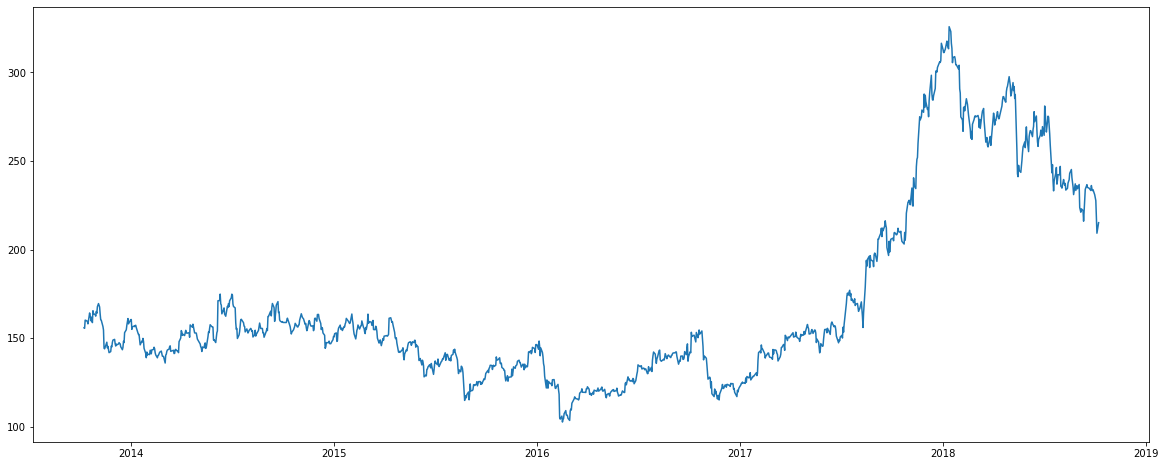

In [5]:
# Load dataset
# Tata global beverage sales
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
display(df.head())
df.info()
# Dataviz
fig,ax1=plt.subplots()
ax1=plt.plot(df["Date"],df["Close"],label='Close Price history')
#ax1=sns.lineplot(ax=ax1, x='Date', y='Close', data=df)

In [6]:
## Preparing data for LSTM
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the time series from the initial dataframe --> called 'values' (np.array)
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
display(df2.head())
df3=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
values=df3.values
display(values.shape)
# integer encode direction
##encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_days = 30
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.head())
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_days = 987
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
n_obs = n_days * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
print(X_train.shape, len(X_train), y_train.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_days, n_features))
X_test = X_test.reshape((X_test.shape[0], n_days, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


(1235, 1)

    var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30    0.238234    0.237113    0.257732    0.257284    0.254594    0.248319   
31    0.237113    0.257732    0.257284    0.254594    0.248319    0.266024   
32    0.257732    0.257284    0.254594    0.248319    0.266024    0.275885   
33    0.257284    0.254594    0.248319    0.266024    0.275885    0.255267   
34    0.254594    0.248319    0.266024    0.275885    0.255267    0.265352   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  ...  var1(t-9)  var1(t-8)  \
30    0.266024    0.275885    0.255267    0.265352  ...   0.258628   0.257508   
31    0.275885    0.255267    0.265352    0.251457  ...   0.257508   0.241596   
32    0.255267    0.265352    0.251457    0.281488  ...   0.241596   0.232631   
33    0.265352    0.251457    0.281488    0.274316  ...   0.232631   0.186688   
34    0.251457    0.281488    0.274316    0.271627  ...   0.186688   0.185119   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-

In [9]:
df3=df3.astype(float)

2022-08-08 19:53:21.389590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/80
50/50 - 4s - loss: 0.0650 - val_loss: 0.1899 - 4s/epoch - 77ms/step
Epoch 2/80
50/50 - 1s - loss: 0.0417 - val_loss: 0.1193 - 671ms/epoch - 13ms/step
Epoch 3/80
50/50 - 1s - loss: 0.0373 - val_loss: 0.0762 - 689ms/epoch - 14ms/step
Epoch 4/80
50/50 - 1s - loss: 0.0350 - val_loss: 0.0440 - 704ms/epoch - 14ms/step
Epoch 5/80
50/50 - 1s - loss: 0.0328 - val_loss: 0.0359 - 649ms/epoch - 13ms/step
Epoch 6/80
50/50 - 1s - loss: 0.0328 - val_loss: 0.0333 - 945ms/epoch - 19ms/step
Epoch 7/80
50/50 - 1s - loss: 0.0272 - val_loss: 0.0537 - 1s/epoch - 29ms/step
Epoch 8/80
50/50 - 1s - loss: 0.0234 - val_loss: 0.0677 - 752ms/epoch - 15ms/step
Epoch 9/80
50/50 - 1s - loss: 0.0186 - val_loss: 0.0620 - 696ms/epoch - 14ms/step
Epoch 10/80
50/50 - 1s - loss: 0.0165 - val_loss: 0.0609 - 662ms/epoch - 13ms/step
Epoch 11/80
50/50 - 1s - loss: 0.0158 - val_loss: 0.0642 - 652ms/epoch - 13ms/step
Epoch 12/80
50/50 - 1s - loss: 0.0157 - val_loss: 0.0592 - 705ms/epoch - 14ms/step
Epoch 13/80
50/50 -

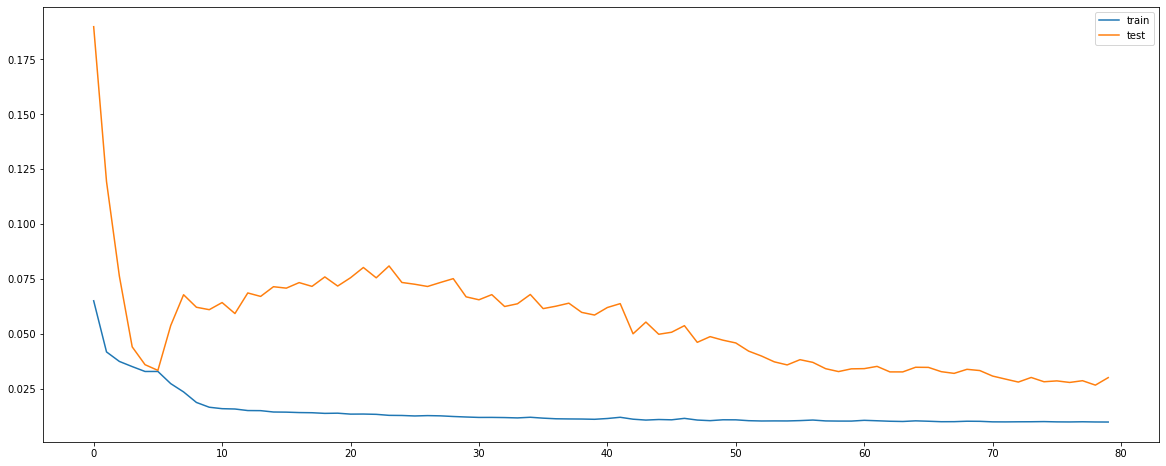

In [11]:
## Model : LSTM(50),Dense(1)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=80, batch_size=20, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

7/7 [==============================] - 1s 6ms/step
Test RMSE: 8.491


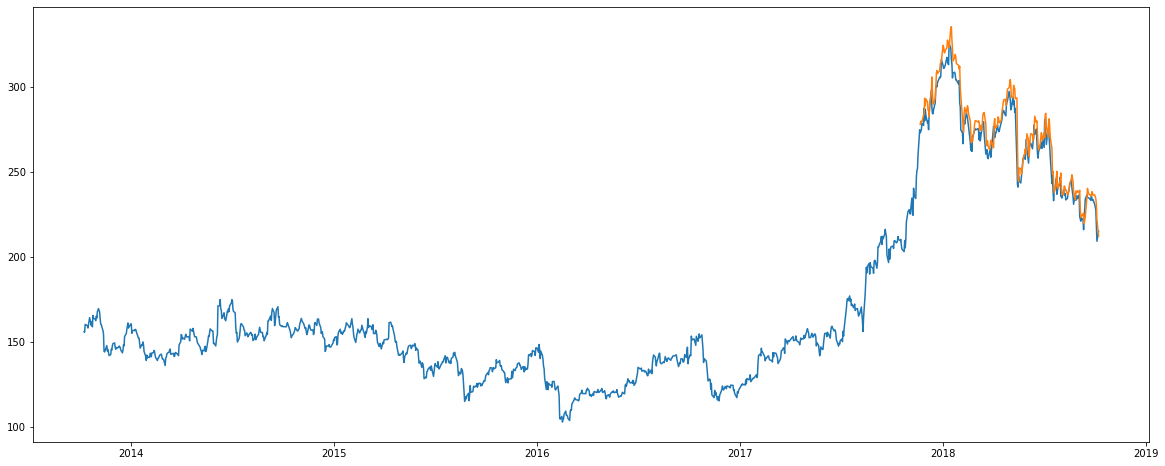

In [12]:
# Make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, - n_features -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, - n_features -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Plot prediction
df_values=df3.Close
d = {'train': df_values, 'test': pd.Series(inv_yhat, index=df_values.index[np.arange(n_train_days+n_days,len(df_values))])}
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


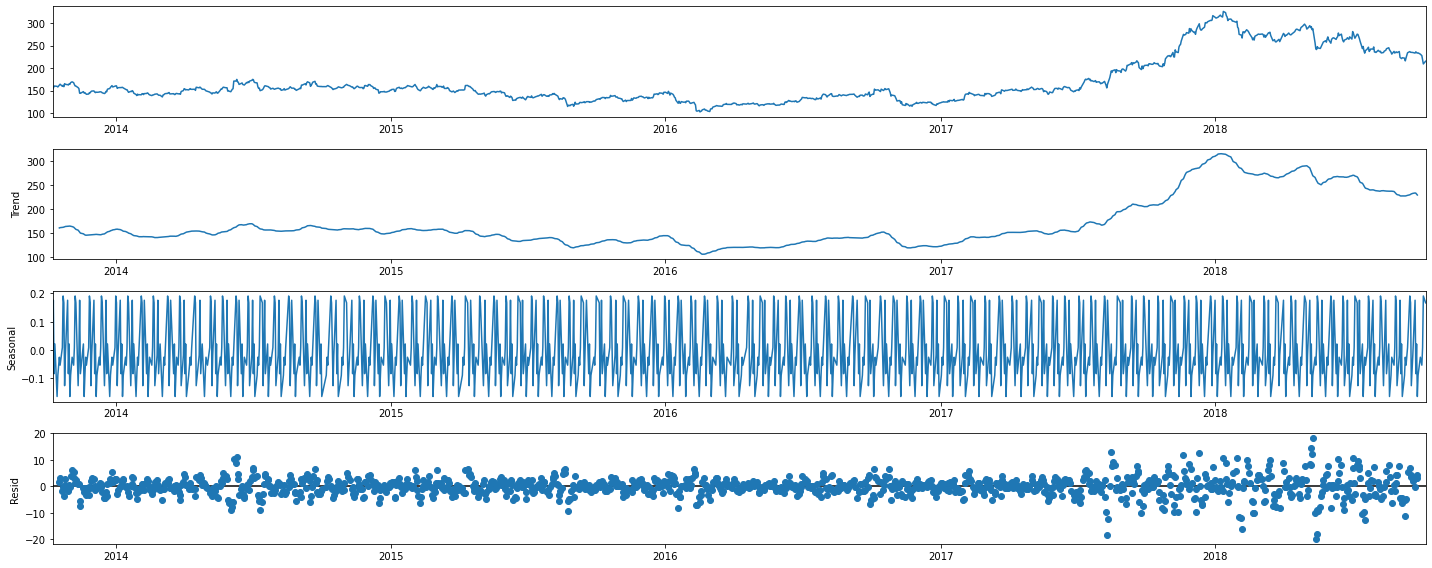

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df3,period=12)
res.plot()
plt.show()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


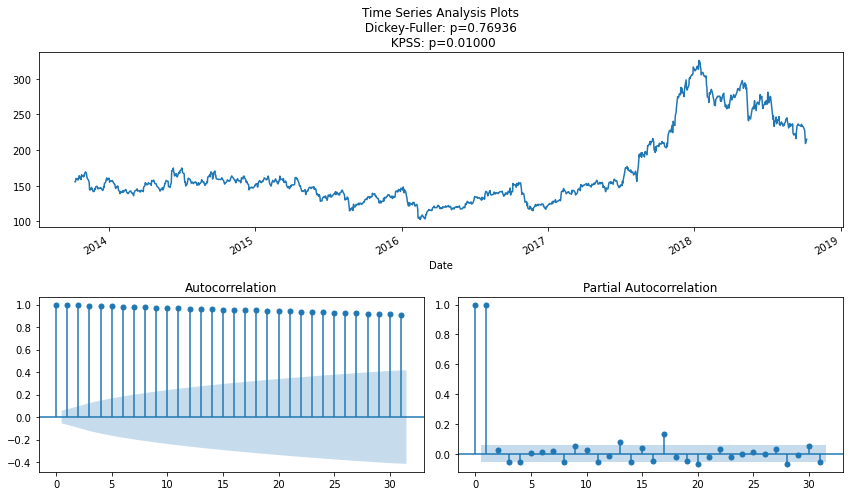

In [14]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate ADF and KPSS tests
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value_ADF = sm.tsa.stattools.adfuller(y)[1]
    p_value_KPSS = sm.tsa.stattools.kpss(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f} \n KPSS: p={1:.5f}'.format(p_value_ADF,p_value_KPSS))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

    
# Selecting the time series from the initial dataframe 
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
display(df2.head())
df3=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
display(df3.head())
tsplot(df3["Close"])

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


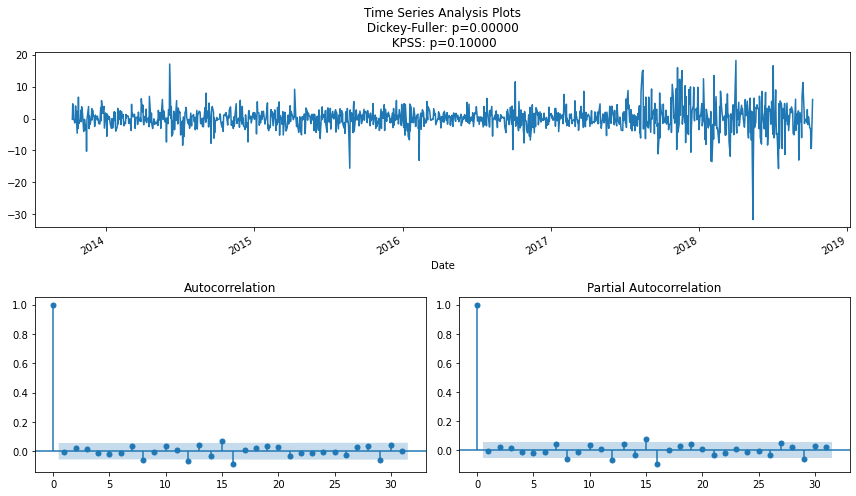

In [15]:
ts_diff = (df3["Close"] - df3["Close"].shift(1)).dropna()
tsplot(ts_diff)

In [88]:
model=sm.tsa.SARIMAX(df3[0:987].astype(float),order=(1,1,0),seasonal_order=(0,1,0,12))
arima=model.fit()
print(arima.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77364D+00    |proj g|=  2.50498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.802D-06   2.774D+00
  F =   2.7736391381991492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  987
Model:      

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


In [107]:
import datetime
t1 = datetime.date(2018,10,5)
t2 = datetime.date(2018,10,8)
pred = arima.predict(t1,t2)
concatpred = pd.concat([df3, pred])#Concaténation des prédictions

plt.plot(concatpred) #Visualisation


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [106]:
print(t1)
print(df3.iloc[1234])

2018-10-08
Close    215.15
Name: 2018-10-08 00:00:00, dtype: object


In [48]:
pred

1235    215.037551
1236    214.925416
1237    214.813595
1238    214.702085
1239    214.590886
1240    214.479998
dtype: float64

In [46]:
df3.tail()

,Close
Date,
2018-10-01,230.9
2018-10-03,227.6
2018-10-04,218.2
2018-10-05,209.2
2018-10-08,215.15


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  987
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -2400.699
Date:                Tue, 09 Aug 2022   AIC                           4811.398
Time:                        14:49:17   BIC                           4835.866
Sample:                             0   HQIC                          4820.704
                                - 987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8272      0.071    -11.718      0.000      -0.966      -0.689
ma.L1          0.8353      0.074     11.278      0.000       0.690       0.980
ma.L2          0.0228      0.029      0.789      0.430      -0.034       0.079
ma.L3          0.0813      0.030      2.699      0.007       0.022       0.140
sigma2         7.6262      0.220     34.624      0.000       7.194       8.058
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               904.35
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

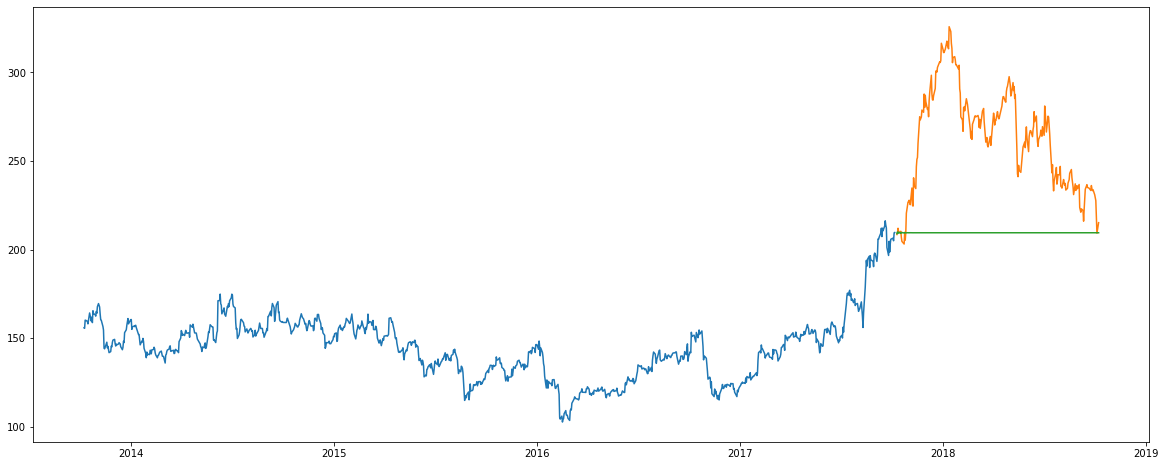

In [76]:
from pmdarima.arima import auto_arima
train=df3[0:987].astype(float)
valid=df3[988:1235].astype(float)
model = auto_arima(y=train, error_action='ignore', suppress_warnings=True)
model.fit(train)
display(model.summary())
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [75]:
from sktime.forecasting.arima import AutoARIMA
train=df3[0:987]
test=df3[988:1234]
forecaster = AutoARIMA(start_p=0,max_p=2, error_action='ignore', suppress_warnings=True)                                      
train = train.astype(float)
forecaster.fit(train)


AutoARIMA(error_action='ignore', max_p=2, start_p=0, suppress_warnings=True)

In [21]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

fh = np.arange(len(test)) + 1
forecast, forecast_int = forecaster.predict(fh=fh)
sun_arima_mae, sun_arima_mape = plot_forecast(
    train, test, forecast, forecast_int
)

/opt/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:751: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  freq = x.freq
/opt/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:752: UserWarning: use of ForecastingHorizon methods with pd.Timestamp carrying freq is deprecated since 0.13.0 and will raise exception from 0.14.0
  warn(
/opt/anaconda3/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:693: FutureWarning: In a future version, calling 'Timestamp.to_period()' without passing a 'freq' will raise an exception.
  cutoff = _coerce_to_period(cutoff, freq=fh.freq)


ValueError: Must supply freq for datetime value